Ref:
1. An introduction to ConvLSTM
    https://medium.com/neuronio/an-introduction-to-convlstm-55c9025563a7
2. How to work with Time Distributed data in a neural network
    https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00
3. A Visual Guide to Recurrent Layers in Keras
    https://amitness.com/2020/04/recurrent-layers-keras/
4. coursera-functional api
    https://www.coursera.org/lecture/customising-models-tensorflow2/multiple-inputs-and-outputs-XVZYB
5. keras - functional api
    https://www.tensorflow.org/guide/keras/functional
6. Advanced Keras — Constructing Complex Custom Losses and Metrics
    https://towardsdatascience.com/advanced-keras-constructing-complex-custom-losses-and-metrics-c07ca130a618
7. tensorflow: save and load model
    https://www.tensorflow.org/tutorials/keras/save_and_load
8. tensorflow: training and evaluation
    https://www.tensorflow.org/guide/keras/train_and_evaluate
9. Write custom callback
    https://www.tensorflow.org/guide/keras/custom_callback/

In [1]:
from Model import TimeCNN, ConvLSTM, factor, input_window, predict_window
import cv2 
import numpy as np
import pandas as pd
import re
import os
import glob
import tqdm
import matplotlib.pyplot as plt
from tensorflow import math, square
from tensorflow.keras import Input, models, optimizers, Model, metrics
from tensorflow.keras.backend import function
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Concatenate, Multiply
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback
#from tensorflow.keras.layers import Conv2D, ConvLSTM2D, BatchNormalization, MaxPooling3D, TimeDistributed, Flatten, Dense, Concatenate, Multiply, Add 
#from tensorflow import concat, split, math, square, constant
#from tensorflow.keras.backend import squeeze, reshape

#force channels-first ordering
from keras import backend
backend.set_image_data_format('channels_first')

Using TensorFlow backend.


## Define size of input ports and output ports 

In [2]:
# 3 days for 1 days prediction

# data size params
file_len = len(glob.glob("./FeatMap/AM/*.npy"))
timesteps = 3 # use 3 hr to predict 1 future hour (3 for 1)
future = 1 #*24
stride = 1
batch_size = None

input_ports = {'atm':(2, 200, 155), # channels: 'Pressure-Corrected AirMass', 'Cosine Incidence Angle' 
               'rain':(2, 200, 155), # channels: 'RH', 'Precp'
               'wind':(3, 200, 155), # channels: 'WS', 'WD_cos', 'WD_sin'
               'cloud':(1, 200, 155) # channels: 'StaImg'
               #'air':(200, 155, 2) # channels: air pollution
              }

target = {'etr':(1, 200, 155), 
          'hour':(1, 200, 155)
         } # elements: 'ETR from SOLPOS', '1h-unit matrix'

## Load input ports and output ports

In [3]:
etr = np.load("./etr_2017.npy")
sample_mask = (np.sum(np.sum(np.sum(etr, axis=-1), -1), -1) != 0.0)

In [4]:
atm = np.load("./atm_2017.npy")[sample_mask]
rain = np.load("./rain_2017.npy")[sample_mask]
wind = np.load("./wind_2017.npy")[sample_mask]
cloud = np.load("./cloud_2017.npy")[sample_mask]
irr = np.load("./irr_2017.npy")[sample_mask]
hour = np.load("./hour_2017.npy")[sample_mask]
shine = np.load("./shine_2017.npy")[sample_mask]
etr = etr[sample_mask]

## Build model

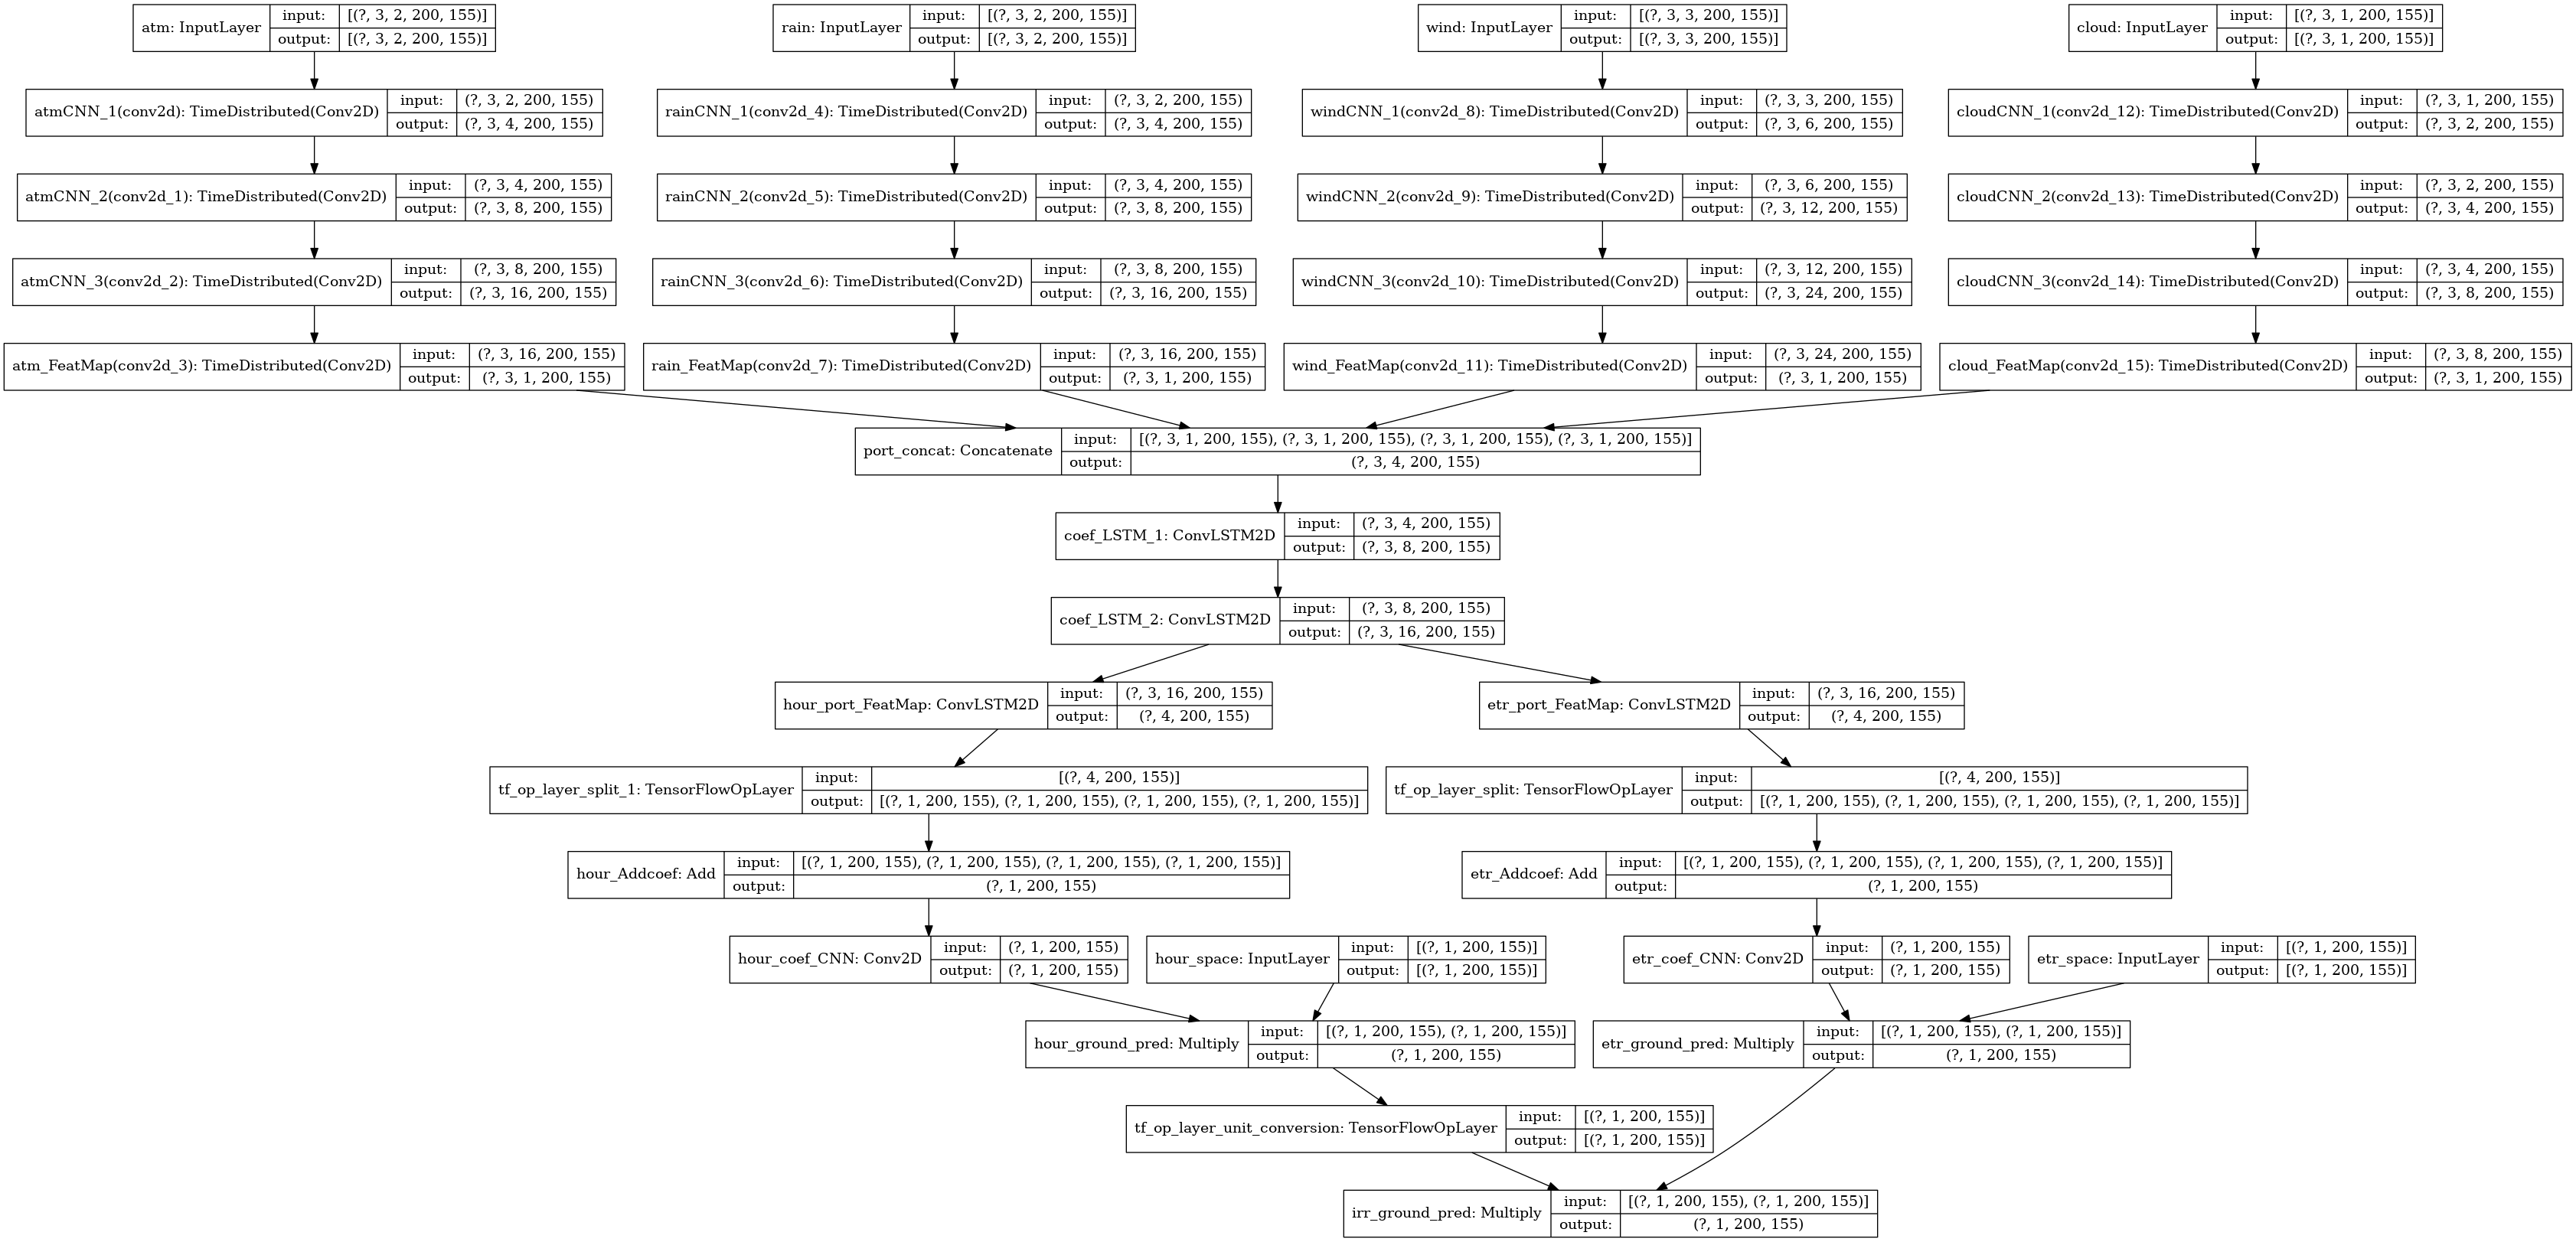

In [5]:
backend.clear_session()
# build model

# create input ports 
space_inputs = [Input(name=f'{key}_space', shape=value, batch_size=batch_size) for key,value in target.items()]
port_inputs = [Input(name=f'{key}', shape=(timesteps,) + value, batch_size=batch_size) for key,value in input_ports.items()]

# TimeDistributed CNN layers
port_FeatMaps = [TimeCNN(i) for i in port_inputs]
#print(inputs)
#print(port_FeatMaps)

# concat layer to stack four feature ports 
port_concat = Concatenate(axis=2, name='port_concat')(port_FeatMaps) # concat axis: channel

# ConvLSTM layers
coef_FeatMap = ConvLSTM(inputs=port_concat)

# two branches for two output ports
pred_Etr, pred_Hour = [factor(inputs=coef_FeatMap, raw=space_inputs[i], port_len=len(input_ports)) for i in range(len(target))]

# unit conversion from ETR[W/m2] to Irr[MJ/m2]
## Irr = ETR*(60*60*Hour)*10^-6
pred_time = math.scalar_mul(3600/1000000, pred_Hour, name='unit_conversion')
pred_Irr = Multiply(name='irr_ground_pred')([pred_Etr, pred_time])

# connect functional api
model = Model(inputs=[port_inputs, space_inputs], outputs=[pred_Irr, pred_Hour])

#model.summary()
plot_model(model, "Model.png", show_shapes=True)

## Custom loss func

In [6]:
def MapLoss(batch_size):
    bool_mask = np.load('./TruthMap/BoolMask.npy') 
    bool_mask = np.repeat(np.expand_dims(np.expand_dims(bool_mask, 0), 0), batch_size, 0)
    #print(bool_mask.shape)
    
    def Loss(y_true, y_pred):
    # computes the mean squared error between the real data and the prediction    
        return math.reduce_mean(square(y_true[bool_mask] - y_pred[bool_mask]))    
    
    return Loss

## Compile the model

In [7]:
batch_size = 1 # 24 hr prediction as a batch

model.compile(
    optimizer=optimizers.RMSprop(1e-3),
    loss={
        "irr_ground_pred": MapLoss(batch_size=batch_size),
        "hour_ground_pred": MapLoss(batch_size=batch_size)
    },
    loss_weights={
        "irr_ground_pred": 1.0,
        "hour_ground_pred": 0.5 # since the hour ground truth accuracy is not high enough
    },
    metrics={
        "irr_ground_pred": [
            metrics.MeanAbsoluteError()
            #metrics.MeanAbsolutePercentageError()
        ],
        "hour_ground_pred": [metrics.MeanAbsoluteError()]
    },
)

## Restore weights

In [8]:
def restore_model():
    # restore the minimul val_loss model
    checkpoints = glob.glob("./Model_mcp/2020-10-31-11:00:30/*.h5")
    search = lambda x: float(re.search(r'\d.\d{4}', x)[0])
        
    if checkpoints:
        best_checkpoint = min(checkpoints, key=search)
        print("Restoring from", best_checkpoint)
        return model.load_weights(best_checkpoint)
    
    print("no checkpoint available")

restore_model()

Restoring from ./Model_mcp/2020-10-31-11:00:30/14_val_loss=0.2553.h5


## Evaluate Daily losses

In [9]:
class Eva_Callback(Callback):
    #def set_params(self, params):
        #params['batch_size'] = params['batch_size']
        #self.params = params
    
    def on_test_batch_end(self, batch, logs=None):
        # ['batch', 'size', 'loss', 'irr_ground_pred_loss', 'hour_ground_pred_loss', 'irr_ground_pred_mean_absolute_error', 'hour_ground_pred_mean_absolute_error']
        print('batch', logs['batch'], logs['loss'], logs['irr_ground_pred_mean_absolute_error'], logs['hour_ground_pred_mean_absolute_error'], logs['irr_ground_pred_loss'],logs['hour_ground_pred_loss'])
        #print("...Evaluating: end of batch {}; IRR: {:.4f}; Hour: {:.4f}".
              #format(batch,logs['irr_ground_pred_loss'], logs['hour_ground_pred_loss']))
        loss.append(logs['loss'])
        IRR_loss.append(logs['irr_ground_pred_loss'])
        Hour_loss.append(logs['hour_ground_pred_loss'])
        return IRR_loss, Hour_loss
    
    def on_predict_batch_end(self, batch, logs=None):
        # ['batch', 'size', 'outputs']
        # output_shape: (2, batch_size, 1, 200, 155); 2 is for irr and hour
        print("batch {}; irr_sum: {}; hour_sum: {}".format(batch, np.sum(logs['outputs'][0]), np.sum(logs['outputs'][1])))
    
    def on_test_begin(self, logs=None):
        print("Start testing")

    def on_test_end(self, logs=None):
        print("Stop testing")
        
    def on_predict_begin(self, logs=None):
        print("Start testing")

    def on_predict_end(self, logs=None):
        print("Stop testing")

In [10]:
# for loop

data_len = atm.shape[0]
loss = []
IRR_loss = []
Hour_loss = []

for i in tqdm.tqdm_notebook(range(data_len)):
    # evaluate the monthly losses with all the traing and val data
    eva = model.evaluate(
        x={"atm": atm[i:i+1], 
           "rain": rain[i:i+1], 
           "wind": wind[i:i+1], 
           "cloud": cloud[i:i+1], 
           "hour_space": hour[i:i+1], 
           "etr_space": etr[i:i+1]
          },
        y={"hour_ground_pred": shine[i:i+1], 
           "irr_ground_pred":irr[i:i+1]
          },
        batch_size=1, 
        verbose=0, 
        #sample_weight=None, 
        steps=None,
        #callbacks=[Eva_Callback(), 
        #          #viz
        #          ], 
        #max_queue_size=10, 
        #workers=1, 
        #use_multiprocessing=False,
    )
    
    loss.append(eva[0])
    IRR_loss.append(eva[1])
    Hour_loss.append(eva[2])

#print(IRR_loss)
#print(Hour_loss)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [13]:
len(loss)

4443

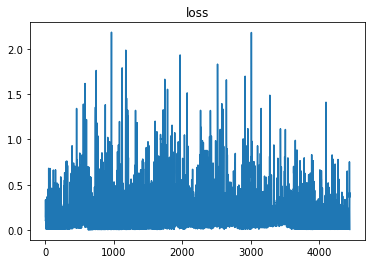

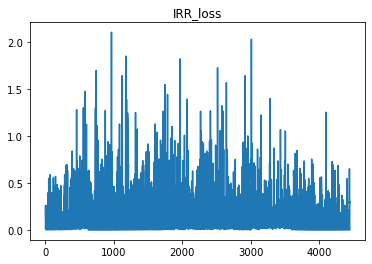

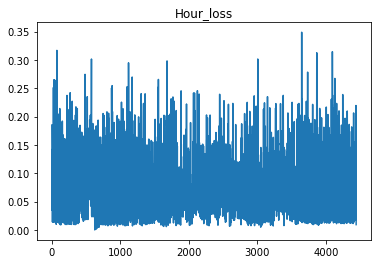

In [11]:
eva_loss = pd.DataFrame({'loss': loss,'IRR_loss':IRR_loss, 'Hour_loss':Hour_loss})
plt.plot(eva_loss['loss'])
plt.title('loss')
plt.show()
plt.plot(eva_loss['IRR_loss'])
plt.title('IRR_loss')
plt.show()
plt.plot(eva_loss['Hour_loss'])
plt.title('Hour_loss')
plt.show()

## Prediction

In [ ]:
ind_pred = 0

outputs = model.predict(
    x={"atm": atm[ind_pred:], 
       "rain": rain[ind_pred:], 
       "wind": wind[ind_pred:], 
       "cloud": cloud[ind_pred:], 
       "hour_space": hour[ind_pred:], 
       "etr_space": etr[ind_pred:]
      },
    batch_size=3,  
    #steps=None, 
    callbacks=[Eva_Callback(), 
              #viz
              ],  
    #max_queue_size=10,
    #workers=1, 
    #use_multiprocessing=False,
    verbose=0
)

In [ ]:
offgrid = (np.array(outputs)[0][0][0] == 0)
img = np.array(outputs)[0][0][0]
img[offgrid] = 0.0
plt.imshow(img, cmap='Spectral')
#plt.savefig('demo_output.png')
img.max()

## Inspect outputs of layers 

In [ ]:
# model layers output
#https://www.kite.com/python/answers/how-to-get-the-output-of-each-layer-of-a-keras-model-in-python
layer_outputs = []
for layer in model.layers[-4:-2]:
    keras_function = function([model.input], [layer.output])
    layer_outputs.append(keras_function([[[atm[10], 
       rain[10], 
       wind[10], 
       cloud[10]], 
       [etr[10],
       hour[10]]]
      , 0]))
print(layer_outputs)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

training_data = np.array([[1], [2], [3], [4]])
result_data = np.array([[2], [4], [6], [8]])

test = Sequential([
    Dense(1, activation="linear", input_shape=(1,))
])

test.compile(loss="mean_squared_error", optimizer="SGD")
test.fit(training_data, result_data, epochs=20, verbose=0)

test_outputs = []
for layer in test.layers:
    test_function = function([test.input], [layer.output])
    test_outputs.append(test_function([training_data, 1]))
print(test_outputs)